# LGBM - basic

In [19]:
#3.10.8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates
import random
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer

from verstack import LGBMTuner
from verstack import lgbm_optuna_tuning

import shap
import lightgbm as lgb

In [61]:
# new raw data
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TPut_data.csv')
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TPur_data.csv')
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TKB_data.csv')
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TH_data.csv')
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TEB_data.csv')
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TChP_data.csv')
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TCaP_data.csv')
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TBGP_data.csv')
pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TBB_data.csv')

pollution_data.replace(' ', np.nan, inplace=True)
pollution_data.dropna(axis = 0, how ='any', inplace = True)
pollution_data = pollution_data.set_index("DATE TIME")
pollution_data['PRCP_AMT'] = pollution_data['PRCP_AMT'].astype(float) #check if site has precipitation before using this

# TPut/TKB/TH/TChP/TBGP/TBB
y = pollution_data.iloc[:,4]
envir = [0,1,2,3,5]
time = [6,7,8]
trig = [9,10,11,12]

# TPur/TCaP - NO PRECIPITATION DATA
#y = pollution_data.iloc[:,4]
#envir = [0,1,2,3]
#time = [5,6,7]
#trig = [8,9,10,11]

# TEB
#y = pollution_data.iloc[:,3]
#envir = [0,1,2,4]
#time = [5,6,7]
#trig = [8,9,10,11]

X = pollution_data.iloc[:, envir + time + trig]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle = False, random_state = 42)

print(X.columns)
print(pollution_data.columns)

Index(['TEMP', 'COND', 'PH', 'AMMONIUM', 'PRCP_AMT', 'Hour of Day',
       'Day of Week', 'Month of Year', 'Half Day sin', 'Half Day cos',
       'Year sin', 'Year cos'],
      dtype='object')
Index(['TEMP', 'COND', 'PH', 'AMMONIUM', 'DOO-MGL', 'PRCP_AMT', 'Hour of Day',
       'Day of Week', 'Month of Year', 'Half Day sin', 'Half Day cos',
       'Year sin', 'Year cos'],
      dtype='object')


In [62]:
# Define SMAPE function
def smape(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100


In [63]:
# Initialize the LightGBM model
model = lgb.LGBMRegressor()

# Train the model
model.fit(
    X_train, y_train, 
    eval_set=[(X_test, y_test)], 
    eval_metric=lambda y_true, y_pred: ('smape', smape(y_true, y_pred), False), 
    early_stopping_rounds=10, 
    verbose=10
)

# Predict on the test set
y_pred = model.predict(X_test)

# Predict on the training set
y_pred_train = model.predict(X_train)

# Calculate SMAPE
smape_value = smape(y_test, y_pred)
print(f"SMAPE: {smape_value:.4f}")

[10]	valid_0's l2: 2.68519	valid_0's smape: 6.09121
[20]	valid_0's l2: 1.95011	valid_0's smape: 4.58805
[30]	valid_0's l2: 1.79163	valid_0's smape: 4.20002
[40]	valid_0's l2: 1.77247	valid_0's smape: 4.11932
[50]	valid_0's l2: 1.76861	valid_0's smape: 4.13541
SMAPE: 4.1096


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

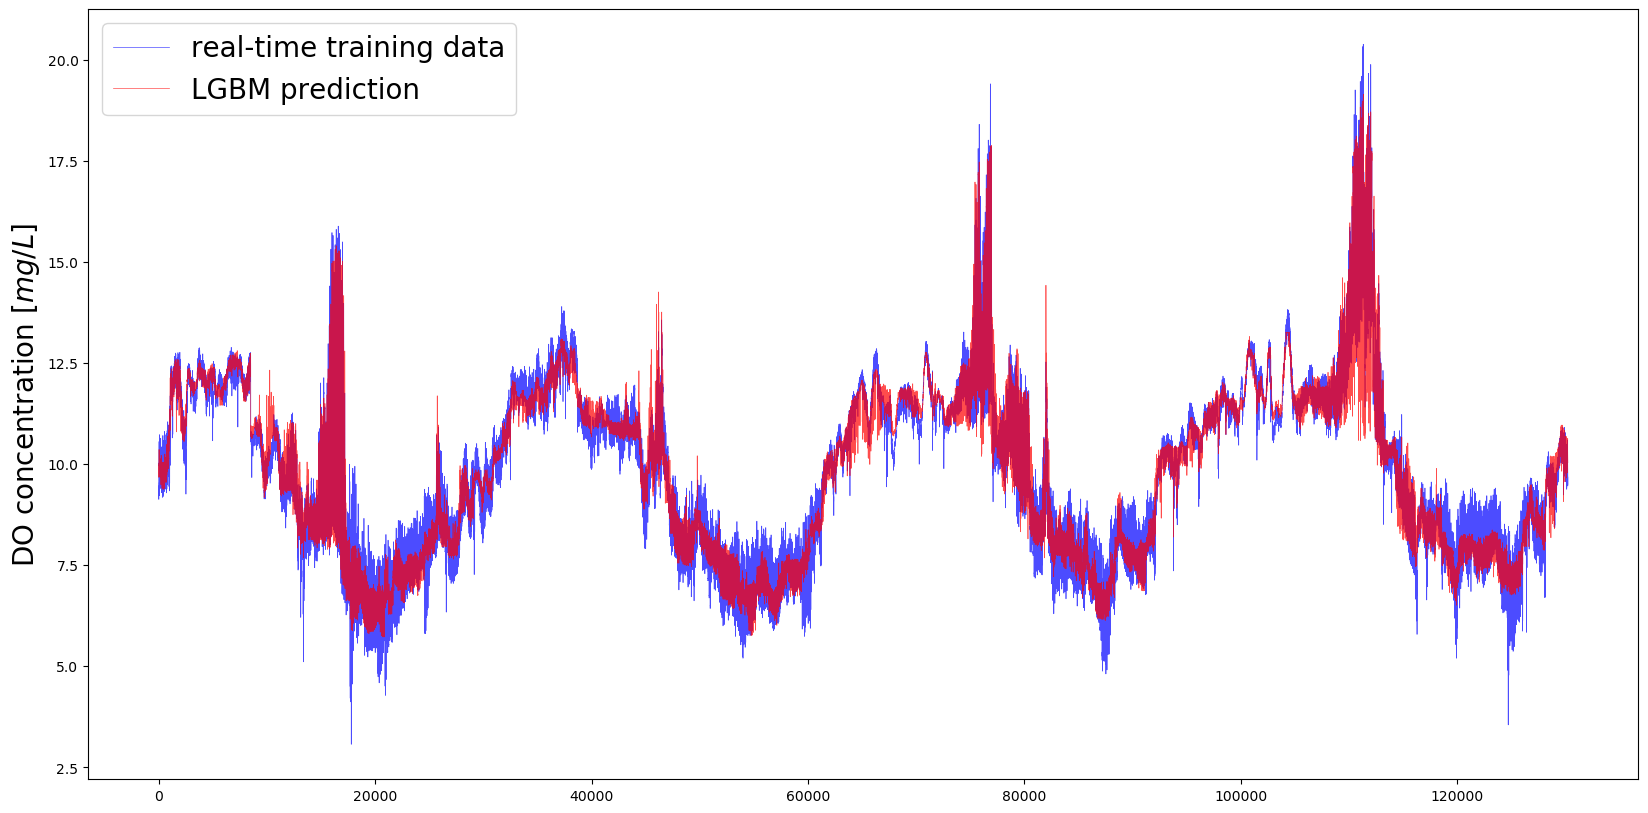

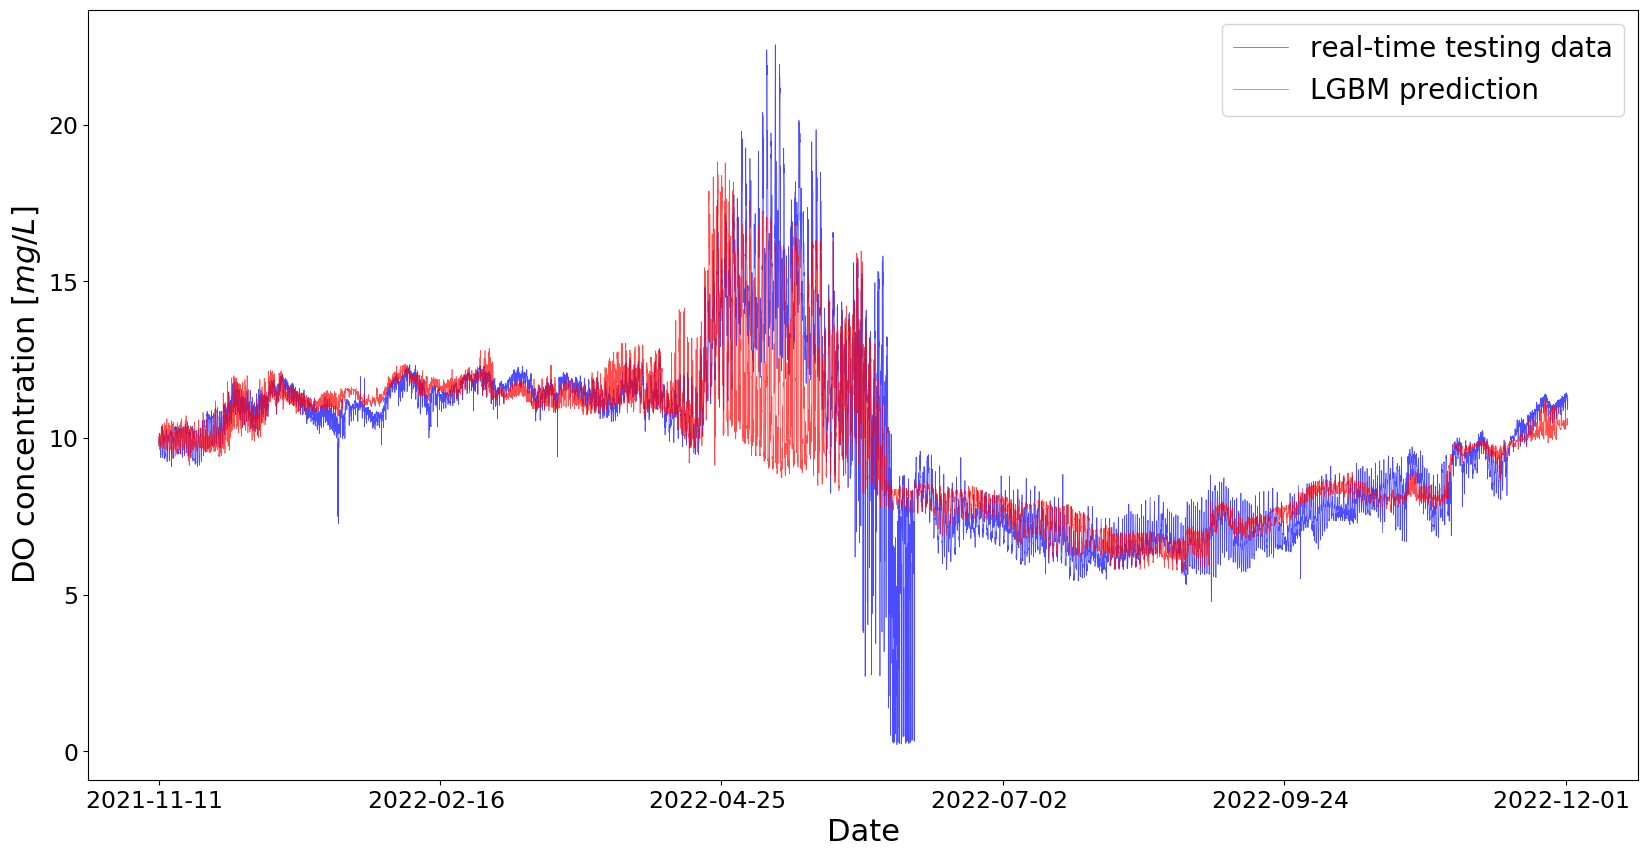

In [64]:
#plot timeseries - training data
fig, (ax) = plt.subplots(1, figsize=(20, 10))
ax.plot(np.array(y_train), color='b',label='real-time training data',linewidth=0.5,alpha=0.7)
ax.plot(np.array(y_pred_train), color='r',label='LGBM prediction',linewidth=0.5,alpha=0.7)

ax.legend(fontsize=20)
ax.set_ylabel('DO concentration [$mg/L$]',fontsize=20)

dates = [x[:11] for x in X_test.index]

#plot timeseries - test data
fig2, (ax2) = plt.subplots(1, figsize=(20, 10))
ax2.plot(X_test.index, np.array(y_test), color='b',label='real-time testing data',linewidth=0.5,alpha=0.7)
ax2.plot(X_test.index, np.array(y_pred), color='r',label='LGBM prediction',linewidth=0.5,alpha=0.7)

ax2.legend(fontsize=20)
ax2.set_ylabel('DO concentration [$mg/L$]',fontsize=22)
ax2.set_xlabel('Date',fontsize=22)

plt.xticks(np.arange(0, len(y_test) + 1, 6500), dates[::6500], fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout

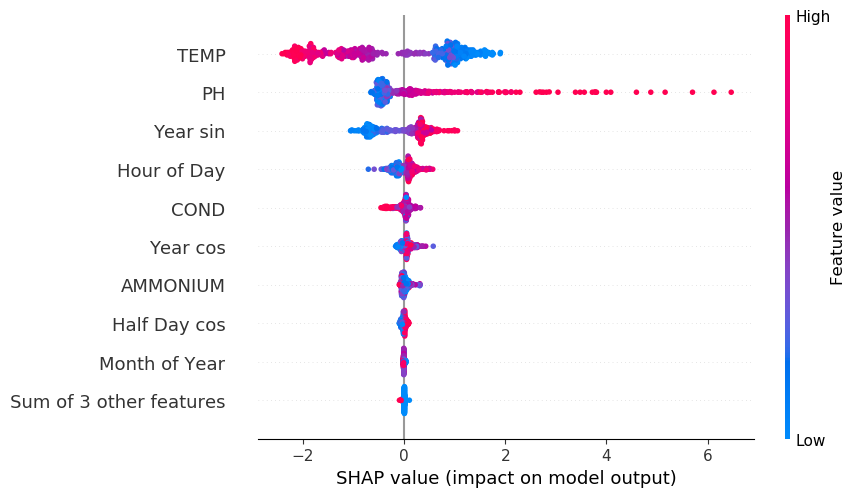

In [65]:
# explain model with SHAP (check feature importances against verstack output), takes a very long time
explainer = shap.Explainer(model)
shap_values = explainer(X_test.sample(500)) #change to 500 random entries, use seed for reproducability
shap.plots.beeswarm(shap_values)